# EDA(Exploratory Data Analysis)

In [491]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [492]:
df = pd.read_parquet("cleaned_data.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63507 entries, 0 to 63506
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       63507 non-null  int64  
 1   Release date                63507 non-null  object 
 2   Estimated owners            63507 non-null  object 
 3   Price                       63507 non-null  float64
 4   Positive                    63507 non-null  int64  
 5   Negative                    63507 non-null  int64  
 6   Achievements                63507 non-null  int64  
 7   Average playtime forever    63507 non-null  int64  
 8   Average playtime two weeks  63507 non-null  int64  
 9   Median playtime forever     63507 non-null  int64  
 10  Median playtime two weeks   63507 non-null  int64  
 11  Developers                  63507 non-null  object 
 12  Publishers                  63507 non-null  object 
 13  Categories                  635

## Korelasyon Analizi

Developers ve Publishers sütunları kendi içerisinde virgüllerle ayrılmış değerler içeriyor. Buna rağmen %66 oranında aynı değer olması gerçek korelasyonun çok daha fazla olduğu anlamına geliyor. Bu yüzden Publisher sütnunu çıkarıyoruz.

In [493]:
# Kaç satırda developer ve publisher aynı?
same_count = (df['Developers'] == df['Publishers']).sum()
total_count = len(df)
print(f"Developer ve Publisher aynı olan satır sayısı: {same_count} / {total_count}")
print(f"Oran: {same_count/total_count:.2%}")


Developer ve Publisher aynı olan satır sayısı: 2563 / 63507
Oran: 4.04%


In [494]:
df = df.drop(columns=["Publishers"])

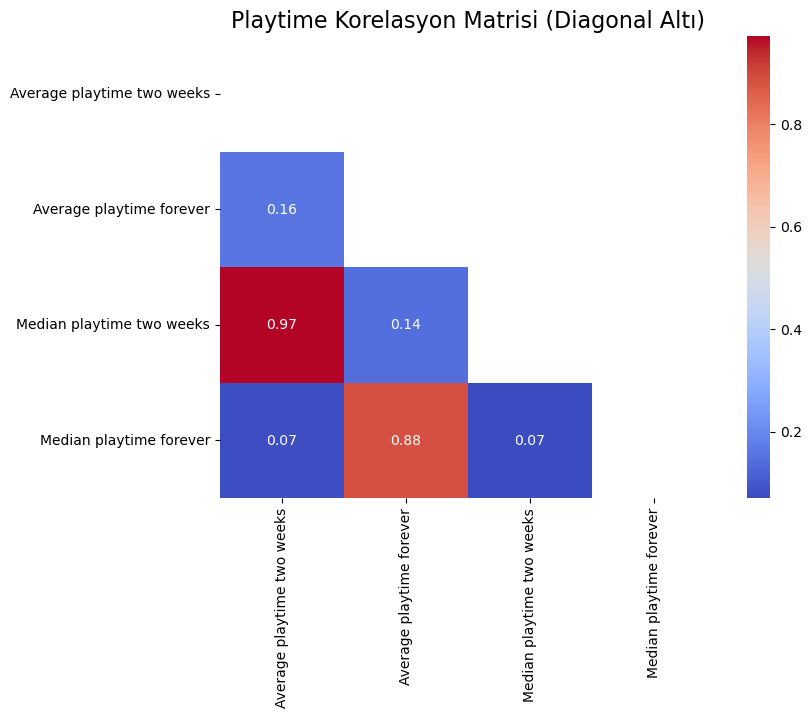

In [495]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

columns_of_interest = ['Average playtime two weeks', 'Average playtime forever', 
                       'Median playtime two weeks', 'Median playtime forever']

# Korelasyon matrisini hesapla
correlation_matrix = df[columns_of_interest].corr()

# Üst üçgeni ve diagonali kesiyoruz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Korelasyon matrisini görselleştiriyoruz
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, cbar=True)

plt.title('Playtime Korelasyon Matrisi (Diagonal Altı)', fontsize=16)
plt.show()


In [496]:
df = df.drop(columns=["Median playtime two weeks", "Median playtime forever"])

## Outlier Analizi

Price için dağılımlar normal görünüyor.Değer çıkarmaya gerek duymadık.

In [497]:

# Fiyat aralıklarını belirle (örnek: 0-5$, 5-10$, 10-20$, ...)
bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]  
labels = [f"${bins[i]}-${bins[i+1]}" for i in range(len(bins)-1)]

# Fiyatları aralıklara ayır
df['Price_range'] = pd.cut(df['Price'], bins=bins, labels=labels, include_lowest=True)

# Her aralıktaki oyun sayısı
price_counts = df['Price_range'].value_counts().sort_index()
print(price_counts)


Price_range
$0-$5         34678
$5-$10        14420
$10-$20       10773
$20-$50        3168
$50-$100        423
$100-$200        41
$200-$500         3
$500-$1000        1
Name: count, dtype: int64


In [498]:
# Release Date analizi yapalım
print(f"\nToplam benzersiz değer: {df['Release date'].nunique()}")
print(f"\nİlk 20 örnek:")
print(df['Release date'].value_counts().head(10))

# NaN kontrolü
print(f"\n\nBoş değer var mı? {df['Release date'].isna().sum()} ({df['Release date'].isna().sum()/len(df)*100:.2f}%)")



Toplam benzersiz değer: 4371

İlk 20 örnek:
Release date
Jan 17, 2020    76
Sep 14, 2018    69
Oct 15, 2020    69
Sep 30, 2021    67
Feb 26, 2021    64
Oct 14, 2021    62
Oct 30, 2020    62
Feb 18, 2021    61
Jun 17, 2021    60
Jul 31, 2020    58
Name: count, dtype: int64


Boş değer var mı? 0 (0.00%)


In [499]:
# Release Date'i datetime'a çevirelim ve feature'lar çıkaralım
import datetime

# Tarihleri datetime'a çevir
df['release_datetime'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')

# Başarısız dönüşümleri kontrol et
failed_conversions = df['release_datetime'].isna().sum()
print(f" Dönüştürülemeyen tarih sayısı: {failed_conversions} ({failed_conversions/len(df)*100:.2f}%)")

if failed_conversions > 0:
    # Geçersiz tarihleri sil
    df = df[df['release_datetime'].notna()].copy()
    print(f" Yeni veri boyutu: {df.shape}")

# 1. Yıl (2020, 2021, 2022, 2023, ...)
df['release_year'] = df['release_datetime'].dt.year

# Mantıksız yılları temizle (gelecek veya çok eski tarihler)
invalid_years = df[(df['release_year'] > 2023) | (df['release_year'] < 1990)].shape[0]
if invalid_years > 0:
    df = df[(df['release_year'] <= 2023) & (df['release_year'] >= 1990)].copy()

# 2. Ay (1-12)
df['release_month'] = df['release_datetime'].dt.month

# 3. Çeyrek (Q1, Q2, Q3, Q4)
df['release_quarter'] = df['release_datetime'].dt.quarter

# 4. Oyunun yaşı (2025'ten kaç yıl önce çıktı)
current_year = 2025
df['game_age_years'] = current_year - df['release_year']

# 5. Mevsim (0=Kış, 1=İlkbahar, 2=Yaz, 3=Sonbahar)
def get_season(month):
    if pd.isna(month):
        return -1  # Unknown için
    if month in [12, 1, 2]:
        return 0  # Kış
    elif month in [3, 4, 5]:
        return 1  # İlkbahar
    elif month in [6, 7, 8]:
        return 2  # Yaz
    else:
        return 3  # Sonbahar

df['release_season'] = df['release_month'].apply(get_season)

# İstatistikler
print("\n Yıl Dağılımı:")
print(df['release_year'].value_counts().sort_index(ascending=False).head(10))

print("\n\n Ay Dağılımı:")
month_names = ['Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran', 
               'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık']
month_dist = df['release_month'].value_counts().sort_index()
for month, count in month_dist.items():
    if not pd.isna(month):
        print(f"{int(month):2}. {month_names[int(month)-1]:10} {count:,} oyun")

print("\n\n Mevsim Dağılımı:")
season_names = {0: 'Kış', 1: 'İlkbahar', 2: 'Yaz', 3: 'Sonbahar', -1: 'Unknown'}
for season, count in df['release_season'].value_counts().sort_index().items():
    print(f"{season_names[season]:10} {count:,} oyun")

print("\n\n Oyun Yaşı İstatistikleri:")
print(df['game_age_years'].describe())

# Orijinal sütunları kaldır
df = df.drop(columns=['Release date', 'release_datetime'])

print(f"5 yeni feature eklendi: release_year, release_month, release_quarter, game_age_years, release_season")
print(f" Yeni veri boyutu: {df.shape}")
print(f" Toplam feature sayısı: {df.shape[1]}")


 Dönüştürülemeyen tarih sayısı: 118 (0.19%)
 Yeni veri boyutu: (63389, 15)

 Yıl Dağılımı:
release_year
2023    6083
2022    7478
2021    9234
2020    8668
2019    7131
2018    7832
2017    6205
2016    4382
2015    2666
2014    1618
Name: count, dtype: int64


 Ay Dağılımı:
 1. Ocak       4,420 oyun
 2. Şubat      4,831 oyun
 3. Mart       5,389 oyun
 4. Nisan      5,072 oyun
 5. Mayıs      5,377 oyun
 6. Haziran    4,712 oyun
 7. Temmuz     5,187 oyun
 8. Ağustos    5,665 oyun
 9. Eylül      5,806 oyun
10. Ekim       6,364 oyun
11. Kasım      5,788 oyun
12. Aralık     4,778 oyun


 Mevsim Dağılımı:
Kış        14,029 oyun
İlkbahar   15,838 oyun
Yaz        15,564 oyun
Sonbahar   17,958 oyun


 Oyun Yaşı İstatistikleri:
count    63389.000000
mean         5.940053
std          2.891379
min          2.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         28.000000
Name: game_age_years, dtype: float64
5 yeni feature eklendi: release_year, release_month, relea

## Kategorik Veirlerin Sayısallaştırılması

Estimated owners için iki aralığın ortalama değerini aldık.

In [500]:
# Orijinal sütunu görelim
print("Orijinal 'Estimated owners' sütunu örnekleri:")
print(df['Estimated owners'].head(), "\n")

# Aralıkları ayır (min ve max)
df[['owners_min', 'owners_max']] = df['Estimated owners'].str.split('-', expand=True)
print("Aralıklar ayrıldı (min ve max):")
print(df[['owners_min', 'owners_max']].head(), "\n")

# Sayısal tipe çevir ve boşlukları temizle
df['owners_min'] = df['owners_min'].str.strip().astype(float)
df['owners_max'] = df['owners_max'].str.strip().astype(float)
print("Sayısal tipe çevrildi:")
print(df[['owners_min', 'owners_max']].head(), "\n")

# Ortalama al
df['Estimated owners numeric'] = df[['owners_min', 'owners_max']].mean(axis=1)
print("Ortalama alınmış sayısal değerler:")
print(df[['Estimated owners', 'Estimated owners numeric']].head())
df = df.drop(columns=["Estimated owners"])


Orijinal 'Estimated owners' sütunu örnekleri:
0         0 - 20000
1         0 - 20000
2         0 - 20000
3         0 - 20000
4    50000 - 100000
Name: Estimated owners, dtype: object 

Aralıklar ayrıldı (min ve max):
  owners_min owners_max
0         0       20000
1         0       20000
2         0       20000
3         0       20000
4     50000      100000 

Sayısal tipe çevrildi:
   owners_min  owners_max
0         0.0     20000.0
1         0.0     20000.0
2         0.0     20000.0
3         0.0     20000.0
4     50000.0    100000.0 

Ortalama alınmış sayısal değerler:
  Estimated owners  Estimated owners numeric
0        0 - 20000                   10000.0
1        0 - 20000                   10000.0
2        0 - 20000                   10000.0
3        0 - 20000                   10000.0
4   50000 - 100000                   75000.0


In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63389 entries, 0 to 63506
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   AppID                       63389 non-null  int64   
 1   Price                       63389 non-null  float64 
 2   Positive                    63389 non-null  int64   
 3   Negative                    63389 non-null  int64   
 4   Achievements                63389 non-null  int64   
 5   Average playtime forever    63389 non-null  int64   
 6   Average playtime two weeks  63389 non-null  int64   
 7   Developers                  63389 non-null  object  
 8   Categories                  63389 non-null  object  
 9   Genres                      63389 non-null  object  
 10  Tags                        63389 non-null  object  
 11  Price_range                 63389 non-null  category
 12  release_year                63389 non-null  int32   
 13  release_month        

Farklı genres türlerinin verideki dağılımlarına bakarak ayırt edici olabilecek değerleri seçerek one-hot-encoding yaptık.

In [502]:
# Genres'lerin ayırt ediciliğini analiz edelim
# orta seviye yaygınlıktaki genres'leri seçelim

total_games = len(df[df['Genres'] != 'Unknown'])
all_genres_filtered = df[df['Genres'] != 'Unknown']['Genres'].str.split(',').explode()
all_genres_filtered = all_genres_filtered.str.strip()
genres_counts = all_genres_filtered.value_counts()

# Her genres'in yüzde dağılımını hesapla
genres_percentages = (genres_counts / total_games * 100).round(2)

print("Genres'lerin yaygınlığı:")
print("="*60)
for i, (genres, pct) in enumerate(genres_percentages.head(30).items(), 1):
    bar = "█" * int(pct / 2)  # Her 2% için bir blok
    print(f"{i:2}. {genres:25} {pct:5.1f}% {bar}")


Genres'lerin yaygınlığı:
 1. Indie                      71.4% ███████████████████████████████████
 2. Action                     43.0% █████████████████████
 3. Casual                     39.7% ███████████████████
 4. Adventure                  39.2% ███████████████████
 5. Strategy                   19.7% █████████
 6. Simulation                 19.7% █████████
 7. RPG                        17.6% ████████
 8. Early Access               12.2% ██████
 9. Free to Play                5.5% ██
10. Sports                      4.7% ██
11. Racing                      3.9% █
12. Massively Multiplayer       2.5% █
13. Utilities                   1.1% 
14. Violent                     0.8% 
15. Design & Illustration       0.7% 
16. Animation & Modeling        0.5% 
17. Education                   0.5% 
18. Gore                        0.5% 
19. Video Production            0.3% 
20. Game Development            0.3% 
21. Audio Production            0.3% 
22. Software Training           0.3% 
23. Nud

In [503]:
# 1. Encode edilecek genre'lar
selected_genres = [
    'Adventure', 'Simulation', 'Strategy', 'RPG', 'Action', 'Casual', 'Indie', 'Sports'
]

print(f"Seçilen {len(selected_genres)} ayırt edici genre:")
print("="*70)
for i, genre in enumerate(selected_genres, 1):
    print(f"{i:2}. {genre}")

# 2. Her genre için binary encoding yap
for genre in selected_genres:
    clean_name = genre.strip().replace(' ', '_').replace('-', '_').replace('&', 'and')
    df[f'genre_{clean_name}'] = df['Genres'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if genre in [g.strip() for g in x.split(',')] else 0)
    )

# 3. "Other" kategorisi: Unknown olmayan ama seçili genre içermeyen oyunlar
def calculate_genre_other(row):
    if row['Genres'] == 'Unknown':
        return 0
    game_genres = [g.strip() for g in row['Genres'].split(',')]
    has_selected_genre = any(g in game_genres for g in selected_genres)
    return 0 if has_selected_genre else 1

df['genre_Other'] = df.apply(calculate_genre_other, axis=1)

# 4. Sonuç istatistikleri
unknown_count = (df['Genres'] == 'Unknown').sum()
genre_columns = [f'genre_{g.strip().replace(" ", "_").replace("-", "_").replace("&", "and")}' for g in selected_genres]
games_with_selected_genres = (df[genre_columns].sum(axis=1) > 0).sum()

print(f"\n\n Sonuç İstatistikleri:")
print("="*70)
print(f"Unknown genre'li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Seçili genre’lerden en az birinde olan: {games_with_selected_genres:,} ({games_with_selected_genres/len(df)*100:.1f}%)")
print(f"Seçili değil ama genre’i olan (Other): {df['genre_Other'].sum():,} ({df['genre_Other'].sum()/len(df)*100:.1f}%)")

# 🧹 5. Orijinal Genres sütununu kaldır
df = df.drop(columns=['Genres'])

print(f"\n {len(selected_genres) + 1} yeni genre sütunu eklendi ({len(selected_genres)} seçili + Other)")
print(f" Yeni veri boyutu: {df.shape}")
print(f" Toplam feature sayısı: {df.shape[1]}")


Seçilen 8 ayırt edici genre:
 1. Adventure
 2. Simulation
 3. Strategy
 4. RPG
 5. Action
 6. Casual
 7. Indie
 8. Sports


 Sonuç İstatistikleri:
Unknown genre'li oyunlar: 73 (0.1%)
Seçili genre’lerden en az birinde olan: 61,922 (97.7%)
Seçili değil ama genre’i olan (Other): 1,394 (2.2%)

 9 yeni genre sütunu eklendi (8 seçili + Other)
 Yeni veri boyutu: (63389, 28)
 Toplam feature sayısı: 28


Farklı kategorilerin verideki dağılımlarına bakarak ayırt edici olaiblecek değeri seçerek one-hot-encoding yaptık.

In [504]:
# Categories için önce analiz yapalım

# Tüm kategorileri ayırıp en popülerlerini bulalım
all_categories = df['Categories'].str.split(',').explode()
print(all_categories.nunique())
print("\n\nEn popüler 20 kategori:")
print(all_categories.value_counts().head(20))


41


En popüler 20 kategori:
Categories
Single-player                 59581
Steam Achievements            31139
Steam Cloud                   16477
Full controller support       13746
Multi-player                  12717
Steam Trading Cards            9661
Partial Controller Support     8825
PvP                            7796
Co-op                          6407
Steam Leaderboards             6002
Online PvP                     5535
Remote Play Together           5367
Shared/Split Screen            4836
Online Co-op                   3477
Shared/Split Screen PvP        3443
Stats                          3190
Shared/Split Screen Co-op      2790
Remote Play on TV              2067
Cross-Platform Multiplayer     1899
Includes level editor          1779
Name: count, dtype: int64


In [505]:
# 1. Encode edilecek kategoriler
selected_categories = [
    'Single-player',
    'Multi-player',
    'Co-op',
    'PvP',
    'Online PvP',
    'Full controller support'
]

print(f" Seçilen {len(selected_categories)} ayırt edici kategori:")
print("="*70)
for i, cat in enumerate(selected_categories, 1):
    print(f"{i:2}. {cat}")

# 2. Her kategori için binary encoding yap
for cat in selected_categories:
    clean_name = cat.strip().replace(' ', '_').replace('-', '_').replace('&', 'and')
    df[f'category_{clean_name}'] = df['Categories'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if cat in [c.strip() for c in x.split(',')] else 0)
    )

#  3. "Other" kategorisi: Unknown olmayan ama seçili kategorilere girmeyen oyunlar
def calculate_category_other(row):
    if row['Categories'] == 'Unknown':
        return 0
    game_cats = [c.strip() for c in row['Categories'].split(',')]
    has_selected_cat = any(c in game_cats for c in selected_categories)
    return 0 if has_selected_cat else 1

df['category_Other'] = df.apply(calculate_category_other, axis=1)

#  4. Sonuç istatistikleri
unknown_count = (df['Categories'] == 'Unknown').sum()
category_columns = [f'category_{c.strip().replace(" ", "_").replace("-", "_").replace("&", "and")}' for c in selected_categories]
games_with_selected_cats = (df[category_columns].sum(axis=1) > 0).sum()

print(f"\n\n Sonuç İstatistikleri:")
print("="*70)
print(f"Unknown category’li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Seçili kategorilerden en az birine sahip olan: {games_with_selected_cats:,} ({games_with_selected_cats/len(df)*100:.1f}%)")
print(f"Seçili değil ama kategoriye sahip (Other): {df['category_Other'].sum():,} ({df['category_Other'].sum()/len(df)*100:.1f}%)")

# 🧹 5. Orijinal Categories sütununu kaldır
df = df.drop(columns=['Categories'])

print(f"\n {len(selected_categories) + 1} yeni category sütunu eklendi ({len(selected_categories)} seçili + Other)")
print(f"Yeni veri boyutu: {df.shape}")
print(f"Toplam feature sayısı: {df.shape[1]}")


 Seçilen 6 ayırt edici kategori:
 1. Single-player
 2. Multi-player
 3. Co-op
 4. PvP
 5. Online PvP
 6. Full controller support


 Sonuç İstatistikleri:
Unknown category’li oyunlar: 914 (1.4%)
Seçili kategorilerden en az birine sahip olan: 62,178 (98.1%)
Seçili değil ama kategoriye sahip (Other): 297 (0.5%)

 7 yeni category sütunu eklendi (6 seçili + Other)
Yeni veri boyutu: (63389, 34)
Toplam feature sayısı: 34


Developer sütunundaki veriler çok dağınık olduğu için her bir sütun özelinde mevcut developerların toplam oyun sayılarının ortalamsını aldık.

In [506]:
# Developers için analiz yapalım

# Tüm developer'ları ayırıp en popülerlerini bulalım
all_devs = df['Developers'].str.split(',').explode()
all_devs = all_devs.str.strip()  # Boşlukları temizle
print("Unique değer sayısı: ", all_devs.nunique())
print("\n\nEn popüler 20 developer:")
print(all_devs.value_counts().head(20))



Unique değer sayısı:  40877


En popüler 20 developer:
Developers
choice of games             155
creobit                     127
laush dmitriy sergeevich    113
koei tecmo games co         105
sokpop collective            99
hosted games                 94
boogygames studios           93
reforged group               89
dnovel                       88
tero lunkka                  87
square enix                  82
elephant games               80
blender games                71
sega                         68
atomic fabrik                67
feral interactive (mac)      66
ripknot systems              62
rewindapp                    62
somer games                  61
cristian manolachi           58
Name: count, dtype: int64


In [507]:
# Developer'lar çok dağınık, her birinin çok az oyunu var
# Alternatif: Developer'ın toplam oyun sayısını feature olarak kullan

# Her developer'ın kaç oyunu olduğunu hesapla
dev_counts = df['Developers'].explode().str.strip().value_counts()

# Her oyun için, o oyunun developer'larının ortalama oyun sayısını hesapla
def get_avg_developer_popularity(dev_string):
    if pd.isna(dev_string):
        return 0
    developers = [d.strip() for d in dev_string.split(',')]
    counts = [dev_counts.get(dev, 1) for dev in developers]
    return sum(counts) / len(counts) if counts else 1

df['developer_avg_game_count'] = df['Developers'].apply(get_avg_developer_popularity)

print("Developer popülaritesi (ortalama oyun sayısı) feature'ı oluşturuldu")
print(f"\nİstatistikler:")
print(df['developer_avg_game_count'].describe())

# Orijinal Developers sütununu kaldır
df = df.drop(columns=['Developers'])

print(f"\n✅ Developer sütunu -> 1 sayısal feature'a dönüştürüldü")
print(f"Yeni veri boyutu: {df.shape}")
print("\nÖrnek değerler:")
print(df[['developer_avg_game_count']].head(10))


Developer popülaritesi (ortalama oyun sayısı) feature'ı oluşturuldu

İstatistikler:
count    63389.000000
mean         6.375352
std         15.502161
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        155.000000
Name: developer_avg_game_count, dtype: float64

✅ Developer sütunu -> 1 sayısal feature'a dönüştürüldü
Yeni veri boyutu: (63389, 34)

Örnek değerler:
   developer_avg_game_count
0                       1.0
1                       3.0
2                       1.0
3                       1.0
4                       1.0
5                       2.0
6                       2.0
7                       4.0
8                       2.0
9                       3.0


Farklı tag'lerin verideki dağılımlarına bakarak ayırt edici olabilecek özelllikleri seçerek one-hot-encoding yaptık.

In [508]:

# Unknown tag sayısı
unknown_count = (df['Tags'] == 'Unknown').sum()
print(f"\n 'Unknown' tag'li oyun sayısı: {unknown_count} ({unknown_count / len(df) * 100:.2f}%)")

# Tüm tag'leri ayırıp en popülerlerini bulalım
all_tags = df['Tags'].str.split(',').explode()
all_tags = all_tags.str.strip()
unique = all_tags.unique()



 'Unknown' tag'li oyun sayısı: 9 (0.01%)


In [509]:
# Tag'lerin ayırt ediciliğini analiz edelim
# Çok yaygın tag'ler (>%30) ve çok nadir tag'ler (<%1) yerine
# orta seviye yaygınlıktaki tag'leri seçelim

total_games = len(df[df['Tags'] != 'Unknown'])
all_tags_filtered = df[df['Tags'] != 'Unknown']['Tags'].str.split(',').explode()
all_tags_filtered = all_tags_filtered.str.strip()
tag_counts = all_tags_filtered.value_counts()

# Her tag'in yüzde dağılımını hesapla
tag_percentages = (tag_counts / total_games * 100).round(2)

print("Tag'lerin yaygınlığı:")
print("="*60)
for i, (tag, pct) in enumerate(tag_percentages.head(30).items(), 1):
    bar = "█" * int(pct / 2)  # Her 2% için bir blok
    print(f"{i:2}. {tag:25} {pct:5.1f}% {bar}")


Tag'lerin yaygınlığı:
 1. Indie                      63.0% ███████████████████████████████
 2. Singleplayer               51.6% █████████████████████████
 3. Action                     45.0% ██████████████████████
 4. Casual                     43.0% █████████████████████
 5. Adventure                  42.0% ████████████████████
 6. 2D                         27.3% █████████████
 7. Strategy                   21.3% ██████████
 8. Simulation                 21.0% ██████████
 9. RPG                        18.7% █████████
10. Puzzle                     17.8% ████████
11. Atmospheric                17.4% ████████
12. 3D                         15.4% ███████
13. Early Access               14.5% ███████
14. Pixel Graphics             14.3% ███████
15. Story Rich                 14.0% ███████
16. Colorful                   13.8% ██████
17. Cute                       12.5% ██████
18. Multiplayer                12.3% ██████
19. Exploration                12.2% ██████
20. Arcade                 

In [510]:
# %12-21 arasındaki ayırt edici tag'leri seçelim
# Simulation, RPG, Puzzle, Atmospheric, 3D, Early Access, Pixel Graphics, 
# Story Rich, Colorful, Cute, Multiplayer gibi

# %12-21 arasındaki tag'leri otomatik olarak seçelim
selected_tags = tag_percentages[(tag_percentages >= 12) & (tag_percentages <= 21)].index.tolist()

print(f"Seçilen {len(selected_tags)} ayırt edici tag (%12-21 arası yaygınlık):")
print("="*70)
for i, tag in enumerate(selected_tags, 1):
    pct = tag_percentages[tag]
    count = tag_counts[tag]
    print(f"{i:2}. {tag:30} {pct:5.1f}% ({count:,} oyun)")

# Her tag için binary encoding yap
for tag in selected_tags:
    # Tag adını temizle (sütun adı için)
    clean_name = tag.strip().replace(' ', '_').replace('-', '_').replace("'", "").replace('&', 'and')
    # Unknown tag'lerde 0, diğerlerinde tag içerip içermediğine bak (virgülle ayrılmış kontrolü)
    df[f'tag_{clean_name}'] = df['Tags'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if tag in [t.strip() for t in x.split(',')] else 0)
    )

# "Other" kategorisi ekle - Unknown olmayan ama seçilen tag'lerde olmayan oyunlar
def calculate_tag_other(row):
    if row['Tags'] == 'Unknown':
        return 0  # Unknown'lar Other'a dahil değil
    # Hiçbir seçili tag'i içermiyorsa Other = 1
    game_tags = [t.strip() for t in row['Tags'].split(',')]
    has_selected_tag = any(tag in game_tags for tag in selected_tags)
    return 0 if has_selected_tag else 1

df['tag_Other'] = df.apply(calculate_tag_other, axis=1)

# İstatistikler
unknown_count = (df['Tags'] == 'Unknown').sum()

print(f"\n\nSonuç İstatistikleri:")
print("="*70)
print(f"Unknown tag'li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Tag'i var ama seçili değil (Other): {df['tag_Other'].sum():,} ({df['tag_Other'].sum()/len(df)*100:.1f}%)")

# Orijinal Tags sütununu kaldır
df = df.drop(columns=['Tags'])

print(f"\n {len(selected_tags) + 1} yeni tag sütunu eklendi ({len(selected_tags)} seçili + Other)")
print(f"Yeni veri boyutu: {df.shape}")
print(f"Toplam feature sayısı: {df.shape[1]}")


Seçilen 13 ayırt edici tag (%12-21 arası yaygınlık):
 1. Simulation                      21.0% (13,294 oyun)
 2. RPG                             18.7% (11,840 oyun)
 3. Puzzle                          17.8% (11,290 oyun)
 4. Atmospheric                     17.4% (11,058 oyun)
 5. 3D                              15.4% (9,769 oyun)
 6. Early Access                    14.5% (9,214 oyun)
 7. Pixel Graphics                  14.3% (9,075 oyun)
 8. Story Rich                      14.0% (8,888 oyun)
 9. Colorful                        13.8% (8,729 oyun)
10. Cute                            12.5% (7,912 oyun)
11. Multiplayer                     12.3% (7,792 oyun)
12. Exploration                     12.2% (7,753 oyun)
13. Arcade                          12.1% (7,675 oyun)


Sonuç İstatistikleri:
Unknown tag'li oyunlar: 9 (0.0%)
Tag'i var ama seçili değil (Other): 11,887 (18.8%)

 14 yeni tag sütunu eklendi (13 seçili + Other)
Yeni veri boyutu: (63389, 47)
Toplam feature sayısı: 47


In [511]:
df.to_parquet("eda_data.parquet", index=False)

In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63389 entries, 0 to 63506
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   AppID                             63389 non-null  int64   
 1   Price                             63389 non-null  float64 
 2   Positive                          63389 non-null  int64   
 3   Negative                          63389 non-null  int64   
 4   Achievements                      63389 non-null  int64   
 5   Average playtime forever          63389 non-null  int64   
 6   Average playtime two weeks        63389 non-null  int64   
 7   Price_range                       63389 non-null  category
 8   release_year                      63389 non-null  int32   
 9   release_month                     63389 non-null  int32   
 10  release_quarter                   63389 non-null  int32   
 11  game_age_years                    63389 non-null  int32   
